## Machine Larnin' Fetal Health
https://github.com/fastai/fastpages#writing-blog-posts-with-jupyter

https://docs.google.com/presentation/d/1De2w1N9WbW4Jo-vJ78iJ6APxHsPsjimzdONXDl8CbcA/edit#slide=id.g8b7806df25_0_15

Cardiotocography (CTG) a technique widely used in pregnancy as a method of assessing fetal well‐being. CTG is a continuous recording of the fetal heart rate, fetal movements, and uterine contractions obtained via ultrasound transducers placed on the mother's abdomen. 

![](2021-11-29-16-51-27.png =200x)
![](2021-11-29-16-49-48.png =200x)

CTG machines write these three time-series of data onto a chart that doctors and nurses can use to classify the fetus into one of three classes: Normal, Suspect (needs attention), and Pathalogical (needs intervention).

https://pubmed.ncbi.nlm.nih.gov/23362805/ The admission CTG: is there any evidence for still using the test?

Obviously translating these squiggles into a decision to do a serious intervention requires a highly trained nurse or doctor, which aren't always available especially in poorer countries. [ref] Then again, research has shown that use of CTG can also lead to a high rate of unnecessary interventions (i.e. false positives.)

Perhaps we can solve both problems at once with machine learning model? Turns out some labeled data is available on the good ole' UCI Machine Learning Repo. 
https://archive.ics.uci.edu/ml/datasets/Cardiotocography

Let's download the excel file of the data:

In [4]:
import requests
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sms
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize': (15.7, 8.27)})

In [5]:
data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls")
filename = "data/CTG.xls"
with open(filename, 'wb') as f:
    f.write(data.content)

In [6]:
raw_data = (
    pd.read_excel('./data/CTG.xls', sheet_name="Raw Data")
    .head(-3)  # remove some summary data rows at the foot of the file
    .tail(-1)  # remove empty first row
)
raw_data.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,0.0,0.0,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,0.0,0.0,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,0.0,0.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
5,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,0.0,0.0,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


The first sheet of the spreadsheet is a very terse summary of the various features in the data we've downloaded. Yes, it would be interesting (and probably more powerful) to apply timeseries ML methods (like RNNs) to the raw time series, but unfortunely the only data we have here are summary statistics. First there's metadata:

| feature  | description        |
| -------- | ------------------ |
| FileName | of CTG examination |
| Date     | of the examination |
| b        | start instant      |
| e        | end instant        |

So we have when and how long each CTG measurement lasted. Nothing too useful except for `e` - `b` (the duration) could have some information (or perhaps indicate bias: did the nurse measure the patient longer in cases where other signs indicated problems?). 

Hmm. There are a lot of repeated filenames, that always pair with one date. There's also an unannotated `SegFile` column.

In [7]:
# Files have only one date each
raw_data.groupby('FileName')['Date'].nunique().value_counts()

1    352
Name: Date, dtype: int64

In [8]:
#SegFiles are the unique identifiers for each row in the dataset
raw_data['SegFile'].nunique() == len(raw_data)

True

In [9]:
# Segfiles under the same FileName can have different diagnoses, but generally don't
# "NSP" is the Normal, Suspect, Pathological target label column
raw_data.groupby('FileName')['NSP'].nunique().value_counts()

1    264
2     80
3      8
Name: NSP, dtype: int64

In [10]:
# The mean duration of each segfile is 13.2 min, but CTG is recommended by experts to be done for at least 20 min. 
# This suggests that longer duration monitoring sessions were split into segments
# That said, start and end times overlap across segments, so...?
raw_data["duration"] = (raw_data["e"] - raw_data["b"]) / 60 # assuming instant is in seconds, covert to minutes
assert raw_data.duration.min() > 0
d = raw_data.groupby('FileName')[['duration']].mean() 
d["seg_count"] =  raw_data.groupby('FileName')[['SegFile']].nunique()
d['total_time'] = d['duration'] * d["seg_count"]
d.mean()

duration      13.175703
seg_count      6.039773
total_time    82.990246
dtype: float64

After doing some research, it seems like each `Segfile` might be a segment of a given patient's full reading. This segmentation was likely done as a [data augmentation step](https://arxiv.org/pdf/1908.02338.pdf), so more labeled data can be squeezed out of fewer CTGs. I'm not certain about this though as documentation for this dataset is extremely sparse. For the purposes of this exercise, I'll explicityly go ahead and assume each sample is independant; if this were a real-life project I'd have to stop here and figure out what's actually going on since this independence assumption is critical.



Next come the features:
| Column Name | description in data file | detailed description from [here](https://res.mdpi.com/d_attachment/entropy/entropy-22-00104/article_deploy/entropy-22-00104-v2.pdf) or other sources
| -------- | ----------------------------------------------------------------------- |-------------|
| LB       | baseline value (SisPorto)                                               | Baseline fetal heart rate: "The baseline FHR is determined by approximating the mean FHR rounded to increments of 5 beats per minute (bpm) during a 10-minute window, excluding accelerations and decelerations and periods of marked FHR variability (greater than 25 bpm). There must be at least 2 minutes of identifiable baseline segments (not necessarily contiguous) in any 10-minute window, or the baseline for that period is indeterminate. In such cases, it may be necessary to refer to the previous 10-minute window for determination of the baseline. An abnormal baseline is termed bradycardia when the baseline FHR is less than 110 bpm; it is termed tachycardia when the baseline FHR is greater than 160 bpm."|
| LBE      | baseline value (medical expert)                                         |  Same as LB but measured by a human expert|
| AC       | accelerations (SisPorto)                                                |"number of increases in FHR over the baseline lasting 15–120 s and reaching a peak of atleast 15 bpm in 60 min"|
| FM       | foetal movement (SisPorto)                                              |Number of fetal movements over the period. When the mother feels movement she pushes a button. |
| UC       | uterine contractions (SisPorto)                                         |Number of contractions over the period, measured by a pressure sensistive belt (tocodynamometer)|
| ASTV     | percentage of time with abnormal short term variability  (SisPorto)     |"percentage of subsequent FHR signals differing<1 bpm "|
| mSTV     | mean value of short term variability  (SisPorto)                        |"mean difference between adjacent FHR signals at 4 Hz on the fetal monitor, after removal of adjacent signals that differ>15 bpm" how big short term variability is, but filtered for some reason|
| ALTV     | percentage of time with abnormal long term variability  (SisPorto)      |"percentage of FHR signals with a difference between minimum and maximum values in a surrounding 1 min window<5 bpm"|
| mLTV     | mean value of long term variability  (SisPorto)                         |"mean difference between max and min FHR in a 1 min sliding window, in segments free ofaccelerations or deceleration"|
| DL       | light decelerations                                                     |"number of decreases in FHR under the baseline lasting 15–120 s, with a minimum amplitude of 15 bpm in 60 min"|
| DS       | severe decelerations                                                    |"number of decreases in FHR under the baseline lasting 120–300 s, with a minimumamplitude of 15 bpm in 60 min" (definition of "intermediate", did not see "severe")|
| DP       | prolongued decelerations                                                |"number of decelerations lasting more than 300 s in 60 min"|
| DR       | repetitive decelerations                                                |No documentation found. Column is all zeros and should be dropped anyway. Still important to note that larger datasets which might have variation could possibly take advantage of this variable|
| Width    | histogram width                                                         |The following varibales are parameters of the "histogram" of FHR samples. |
| Min      | low freq. of the histogram                                              |""|
| Max      | high freq. of the histogram                                             |""|
| Nmax     | number of histogram peaks                                               |""|
| Nzeros   | number of histogram zeros                                               |""|
| Mode     | histogram mode                                                          |""|
| Mean     | histogram mean                                                          |""|
| Median   | histogram median                                                        |""|
| Variance | histogram variance                                                      |""|
| Tendency | histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric |""|

There are several human-labeled target class columns, but we only care about NSP (Normal=1; Suspect=2; Pathologic=3). We can't include the others because that would require an expert human element to our system of automatic classification. 

It's important to take some time to get to know what all this stuff actually means. "SisPorto" is the name of the [CTG device company](http://www.omniview.eu/ing/overview) founded by the guys who generated this dataset. It automaticaly generates all features labeled as such. Some of the same variables seem to be documented [here](https://res.mdpi.com/d_attachment/entropy/entropy-22-00104/article_deploy/entropy-22-00104-v2.pdf).

### LB and LBE

In [11]:
# Two reading are pefectly correlated, so will need to drop one
# Also we don't really want human expert input being used in an automatic
# classification model
(raw_data['LB'] == raw_data["LBE"]).value_counts()

True    2126
dtype: int64


### FM      
#### foetal movement (SisPorto)

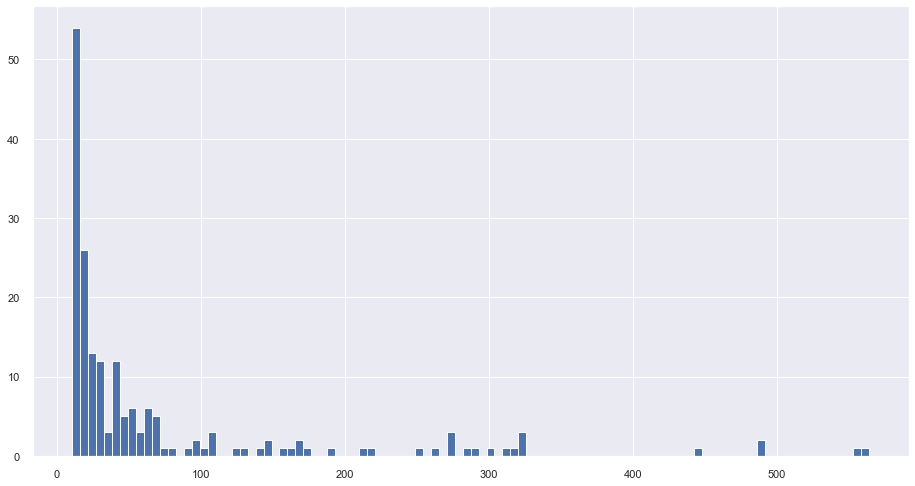

<AxesSubplot:xlabel='duration', ylabel='FM'>

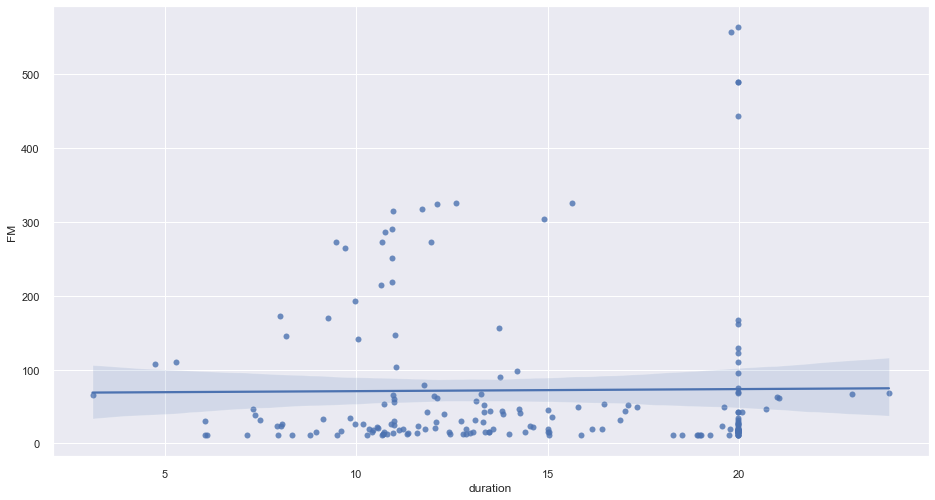

In [12]:
# Huge outliers needs closer examination
# Hard to believe fetus is moving hundreds of times in only a few minutes
# Maybe some mothers just love pushing the button?
# Since #movements is uncorrelated with duration AND other varible definitions
# seem to be time normalize, I don't think we need to normalize this
tail_FM = raw_data[raw_data.FM > 10]
tail_FM.FM.hist(bins=100)
plt.show()
tail_FM.duration.describe()
sns.regplot(x="duration", y="FM", data=tail_FM)
# plt.show()
# sns.regplot(x="duration", y="FM", data=raw_data)

### DS
#### severe decelerations 


<AxesSubplot:xlabel='DS', ylabel='NSP'>

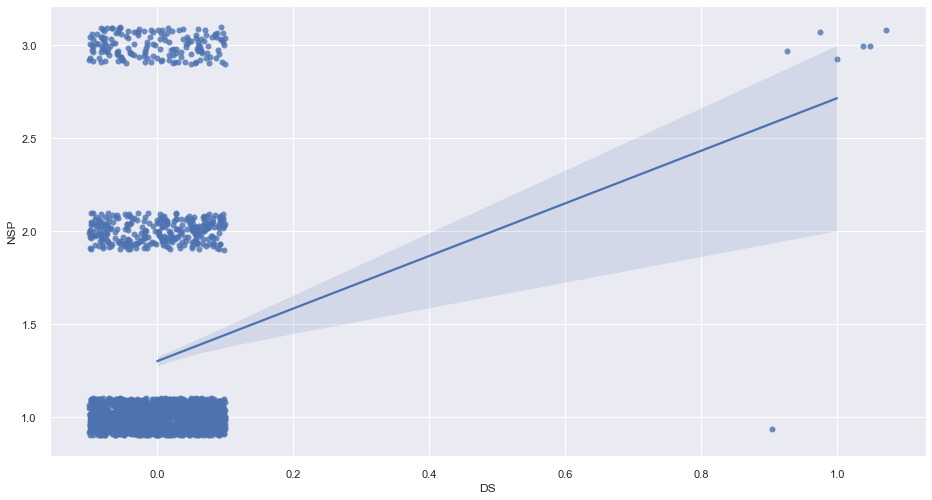

In [13]:
# Very rare condition, but strongly indicative of pathology
sns.regplot(x='DS', y="NSP",data=raw_data, x_jitter=.1, y_jitter=.1)

### Width, Min, Max
The "histogram" of FHR samples. Width = Max - Min, so should drop one of these 

R2: 1.0


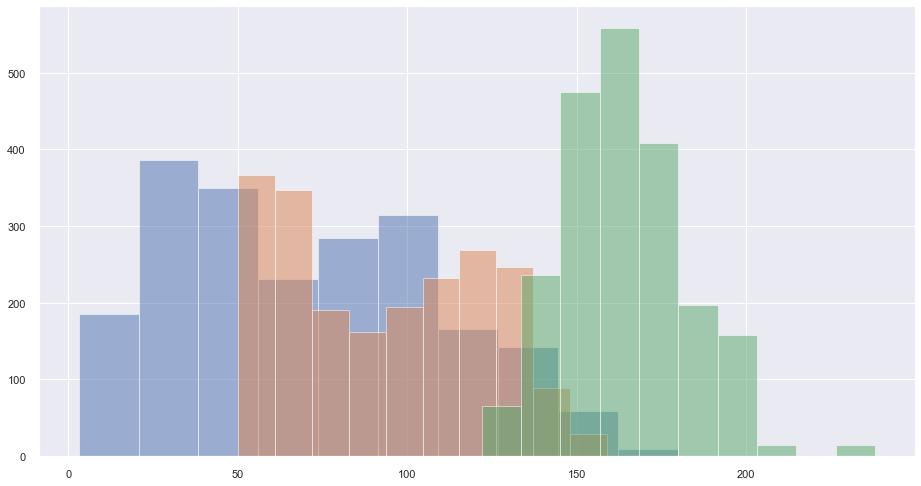

In [14]:
raw_data.Width.hist(alpha=.5)
raw_data.Min.hist(alpha=.5)
raw_data.Max.hist(alpha=.5)
# perfect fit between min, max, and width. 
print("R2:", sms.ols("Width ~ Min + Max", raw_data).fit().rsquared)

### Mean, Median, Mode     
#### histogram metrics

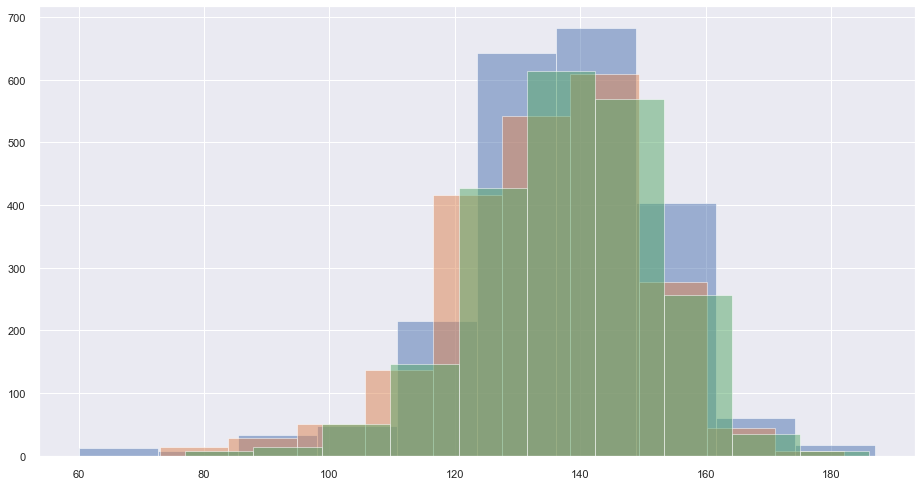

In [15]:
raw_data.Mode.hist(alpha=.5)
raw_data.Mean.hist(alpha=.5)
raw_data.Median.hist(alpha=.5)
plt.show()

<AxesSubplot:xlabel='LB', ylabel='Median'>

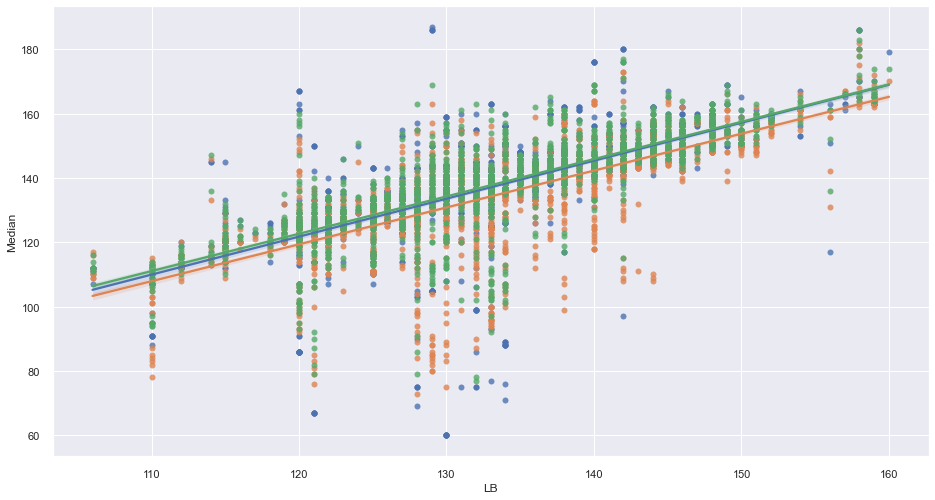

In [16]:
# Highly correlated with baseline FHR
sns.regplot(x="LB", y="Mode", data=raw_data)
sns.regplot(x="LB", y="Mean", data=raw_data)
sns.regplot(x="LB", y="Median", data=raw_data)

Based on these definitions, and looking at correlations, we don't need to normalize count data by duration time. 

Also some of the metrics are only "in absence of accelerations or decellerations" so might need normalization there too. Apprently it's important to see of decellerations coincide with contractions (makes sense, as the baby's hr decreases when it's getting squeezed, then goes back to normal). 

In [17]:
FEATURES = [ 
    # 'b', 'e',  don't use begin or end times
    'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 
    # 'DR' all zeros, so dropped
    'DL', 'DS', 'DP', 
    # 'Width', as said above, Width is perectly derivable from Min and Max
    # so would only lead to multicollinearity and coefficiant instability
    'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 
    # "duration" excluded since count variables seem to already be normalized 
    # AND because this could lead to a selection bias where longer
    # monitored patients were more likely to be pathological (thus leading 
    # to human "expertise leak" into the model, we don't include duration)
]

TARGET = "NSP"
ALL_COLUMNS = FEATURES + [TARGET]
raw_data_filtered = raw_data[ALL_COLUMNS]
px.imshow(raw_data_filtered.corr(method='spearman'))

There are a number of highly correlated variables, especially among the histogram metadata. This lead me to think, some PCA will be helpful for removing noise.

Looking at the PCA plot below, we can see this is true (for example Mean-Median-Mode and LB could probably be replaced with two component vectors). 

Additionally, we can more clearly see that Pathological cases tend to be outliers, while suspect cases (though sometimes more extreme) are aso mixed pretty well within the main cluster of normal cases. This leads me to believe a simple Nearest Neighbors approach might work quite well. Also, even though this is theoretically an ordianal weighting system, there isn't necessarily a graduated ring of orange "S"s between the blue "N"s and green "P"s. I.e. S and P seem somewhat orthogonal. This is also reinforced in the variable histogram grid below. 

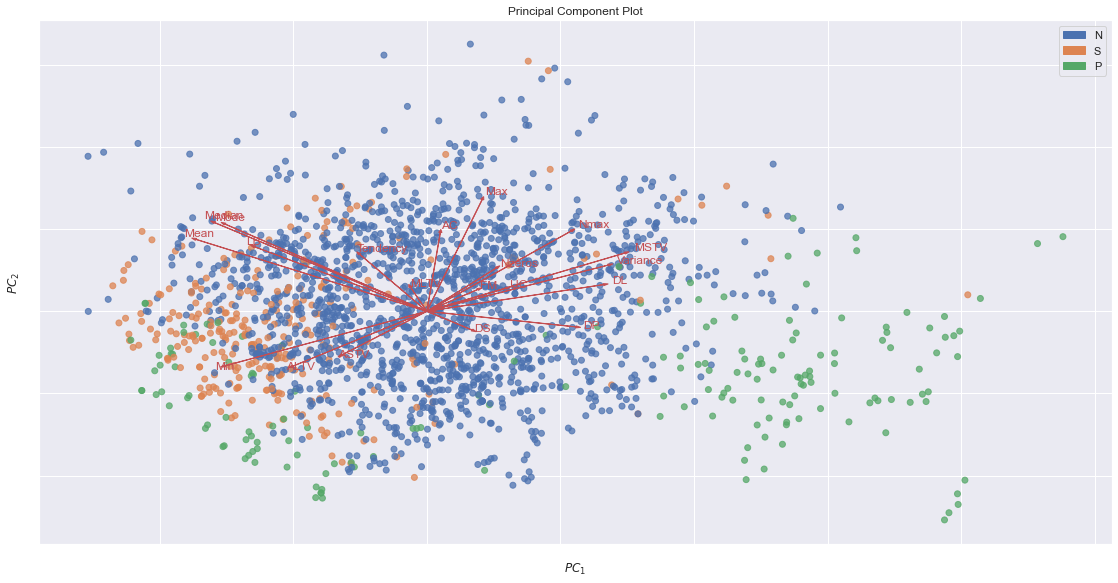

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [80]:
from yellowbrick.features import PCA

X = raw_data_filtered[FEATURES]
y = (raw_data_filtered[TARGET] - 1).astype(int)
visualizer = PCA(scale=True, proj_features=True, classes=['N', 'S', 'P'])
visualizer.fit_transform(X, y)
visualizer.show()

In [81]:
# Classes are highly imbalanced, might need SMOTE?
px.pie(raw_data_filtered, names='NSP', color="NSP",
    color_discrete_map={1:'blue',
                        2:'orange',
                        3:'green', 
                        } 
)

In [19]:
# Not a ton of obvious sperability of classes based on any of these variables
# Low mean/median/mode -> Pathology, but not low LB
# High ASTV -> pathology, low ASTV -> Normal
# High ALTV -> pathology, low ASTV -> Normal
# High AC -> Normal
# High DP -> Pathological
# DS -> Pathological
# High or low variance -> Pathological
# High or low min -> Pathological
# Low MLTV -> pathological
melted = raw_data_filtered.melt("NSP")
fig = px.histogram(melted, x="value", color="NSP", facet_col="variable", facet_col_wrap=5, opacity=.5, barmode='overlay', nbins=1000, 
                #    histnorm='probability density'
                   )
fig.update_yaxes(matches=None)
fig.update_xaxes(matches=None)
fig.show()

In [49]:
raw_data_filtered.to_csv('data/preprocessed_data.csv')